In [35]:
%load_ext autoreload
%autoreload 2

from utils import get_exp_data, downsample_arr, steps2ms
from pathlib import Path

import numpy as np
import pandas as pd 
from scipy.stats import zscore
from scipy.ndimage import uniform_filter1d
from scipy.signal.windows import cosine as cosine_filter
import matplotlib.pylab as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Raw data

In [2]:
# load matlab data file
matlab_file = Path(r'./data/EphysData/A026-20200323-01.mat')
dfs_raw, good_trials = get_exp_data(matlab_file)
dfs_raw = [ dfs_raw[i] for i in good_trials ] # select only good trials

print('There are {} trials'.format(str(len(dfs_raw))))

feat = [ i for i in dfs_raw[0].columns if not i.startswith('unit_') ]
targ = [ i for i in dfs_raw[0].columns if i.startswith('unit_') ]
print('The features are')
print('    ', ' '.join(feat))

print('The targets are')
for i in range(0, len(targ), 10):
    print('    ', ' '.join(targ[i:i+10]))

There are 109 trials
The features are
     distance licks reward_on reward_off cue_on cue_off blackout_on blackout_off
The targets are
     unit_1 unit_2 unit_3 unit_4 unit_5 unit_6 unit_7 unit_8 unit_9 unit_10
     unit_11 unit_12 unit_13 unit_14 unit_15 unit_16 unit_17 unit_18 unit_19 unit_20
     unit_21 unit_22 unit_23 unit_24 unit_25 unit_26 unit_27 unit_28 unit_29 unit_30
     unit_31 unit_32 unit_33 unit_34 unit_35 unit_36 unit_37 unit_38 unit_39 unit_40
     unit_41 unit_42 unit_43 unit_44 unit_45 unit_46 unit_47 unit_48 unit_49 unit_50
     unit_51 unit_52 unit_53 unit_54 unit_55 unit_56 unit_57 unit_58 unit_59 unit_60
     unit_61 unit_62 unit_63 unit_64 unit_65 unit_66 unit_67 unit_68 unit_69 unit_70
     unit_71 unit_72 unit_73 unit_74 unit_75 unit_76 unit_77 unit_78 unit_79 unit_80
     unit_81 unit_82 unit_83 unit_84


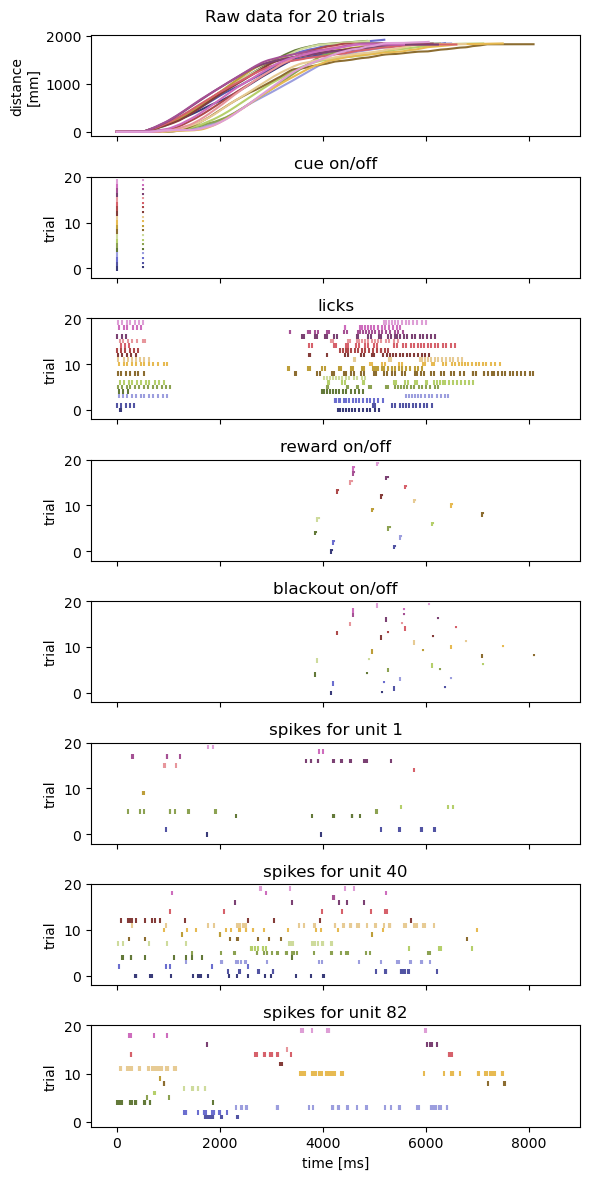

In [30]:
# plot data
dfs = [ dfs_raw[i] for i in range(20) ] # select first 20 trials

fig, axarr = plt.subplots(nrows=8, figsize=(6, 12))
fig.suptitle('Raw data for {} trials'.format(len(dfs)))
plt.set_cmap('jet')
color = lambda x: plt.cm.tab20b(x / len(dfs))



def plot(col):
    'plot columns col from list of dataframes'
    for i, df in enumerate(dfs):
        y = df.loc[:, col]
        x = steps2ms(np.arange(len(y)))
        ax.plot(x, y, color=color(i))

def raster(col, l='-'):
    'plot columns col from list of dataframes'
    for i, df in enumerate(dfs):
        t = df.loc[:, col]
        x = np.where(t == 1)[0]
        x = steps2ms(x)
        ax.eventplot(x, lineoffsets=i, color=color(i), ls=l)

ax = axarr[0]
plot('distance')
ax.set_ylabel('distance\n[mm]')

ax = axarr[1]
raster('cue_on')
raster('cue_off', l=':')
ax.set_title('cue on/off')

ax = axarr[2]
raster('licks')
ax.set_title('licks')

ax = axarr[3]
raster('reward_on')
raster('reward_off', l=':')
ax.set_title('reward on/off')

ax = axarr[4]
raster('blackout_on')
raster('blackout_off', l=':')
ax.set_title('blackout on/off')

ax = axarr[5]
raster('unit_1')
ax.set_title('spikes for unit 1')

ax = axarr[6]
raster('unit_40')
ax.set_title('spikes for unit 40')

ax = axarr[7]
raster('unit_82')
ax.set_title('spikes for unit 82')

for ax in axarr[:-1]:
    ax.set_xticklabels([])
for ax in axarr[1:]:
    ax.set_ylabel('trial')
    ax.set_ylim(top=len(dfs))
for ax in axarr:
    ax.set_xlim(-500, 9000)
ax.set_xlabel('time [ms]')

fig.tight_layout()

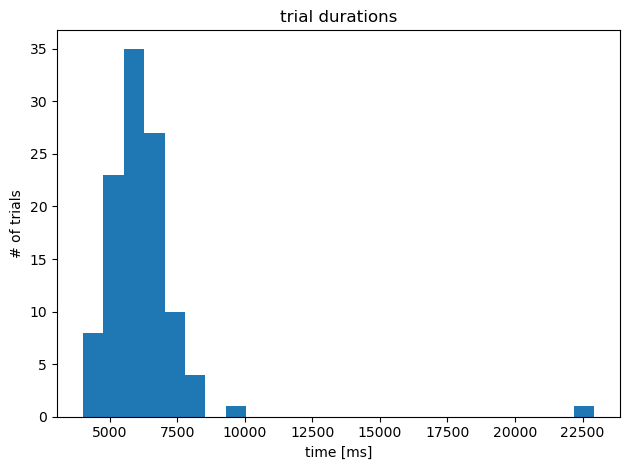

In [31]:
# plot trial durations
trial_ts = np.array([len(df.loc[:, 'distance']) for df in dfs_raw])

fig, axarr = plt.subplots()
ax = axarr
ax.hist(steps2ms(trial_ts), bins=25)

ax.set_xlabel('time [ms]')
ax.set_ylabel('# of trials')
ax.set_title('trial durations')

fig.tight_layout()

# Data processing 

In [92]:
# new dataframes for processed data
dfs_proc = [ pd.DataFrame(dtype=float) for df in dfs_raw]

norm = lambda x: zscore(x) # normalize: subtract mean and normalize by standard deviation
smooth = lambda x, w: uniform_filter1d(x, size=w, mode='nearest')  # smooth by taking average 
convolve = lambda x, w: np.convolve(x, cosine_filter(w), mode='same') # convolve with cosine

for i, _ in enumerate(dfs_raw):
    # generate distance-based features, normalize and smooth

    # distance
    dst_raw = dfs_raw[i].loc[:, 'distance']
    dst_norm = norm(dst_raw)
    dst = smooth(dst_norm, w=25*20)
    dfs_proc[i].loc[:, 'dst'] = dst

    # distance^2
    dst2_raw = dst_raw**2
    dst2_norm = norm(dst2_raw)
    dst2 = smooth(dst2_norm, w=25)
    dfs_proc[i].loc[:, 'dst^2'] = dst2

    # distance^3
    dst3_raw = dst_raw**3
    dst3_norm = norm(dst3_raw)
    dst3 = smooth(dst3_norm, w=25)
    dfs_proc[i].loc[:, 'dst^3'] = dst3

    # velocity
    vel_raw = np.clip(np.round(np.diff(dst_raw, prepend=dst_raw[1] - dst_raw[0]), 5), 0, np.inf) # TODO plot features/rewrite
    vel_norm = norm(vel_raw)
    vel = smooth(vel_norm, w=25)
    dfs_proc[i].loc[:, 'vel'] = vel

    # acceleration
    acc_raw = np.round(np.diff(vel_raw, prepend=vel_raw[1]-vel_raw[0]), 5) # TODO plot features/rewrite
    acc_norm = norm(acc_raw)
    acc = smooth(acc_norm, w=25)
    dfs_proc[i].loc[:, 'acc'] = acc


    # convolve time-event features with raised cosines
    # licks
    lck_train = dfs_raw[i].loc[:, 'licks']
    lck_conv = convolve(lck_train, w=10) # orig: w=13)
    dfs_proc[i].loc[:, 'lck'] = lck_conv

    # rewards 
    rwd_train = dfs_raw[i].loc[:, 'reward_on'] # ignoring reward off for now
    rwd_conv = convolve(rwd_train, w=13)
    dfs_proc[i].loc[:, 'rwd'] = rwd_conv

    # cues
    cue_on_train = dfs_raw[i].loc[:, 'cue_on']
    cue_off_train = dfs_raw[i].loc[:, 'cue_off']
    # TODO

    # blackouts
    blk_on_train = dfs_raw[i].loc[:, 'blackout_on'] 
    blk_off_train = dfs_raw[i].loc[:, 'blackout_off']
    # TODO
    

    # spikes
    for j in targ:
        spk_train = dfs_raw[i].loc[:, j]
        spk_conv = convolve(spk_train, w=13)
        dfs_proc[i].loc[:, j] = spk_conv

In [93]:

for i, _ in enumerate(dfs_raw):
    # cues
    cue_on_train = dfs_raw[i].loc[:, 'cue_on']
    cue_off_train = dfs_raw[i].loc[:, 'cue_off']
    idx_on, idx_off = np.argmax(cue_on_train), np.argmax(cue_off_train)
    idx_basis = np.linspace(idx_on, idx_off, 10)
    idx_basis = np.round(idx_basis).astype(int)
    for j, k in enumerate(idx_basis):
        x = np.zeros_like(cue_on_train)
        x[k] = 1
        conv = convolve(x, w=100)
        dfs_proc[i].loc[:, 'cue_{}'.format(str(j))] = conv
    


    # blackouts
    blk_on_train = dfs_raw[i].loc[:, 'blackout_on']
    blk_off_train = dfs_raw[i].loc[:, 'blackout_off']





C:\Users\spillern\AppData\Local\Temp\ipykernel_72844\4129854894.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_proc[i].loc[:, 'cue_{}'.format(str(j))] = conv
C:\Users\spillern\AppData\Local\Temp\ipykernel_72844\4129854894.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_proc[i].loc[:, 'cue_{}'.format(str(j))] = conv
C:\Users\spillern\AppData\Local\Temp\ipykernel_72844\4129854894.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

# TODO plotting

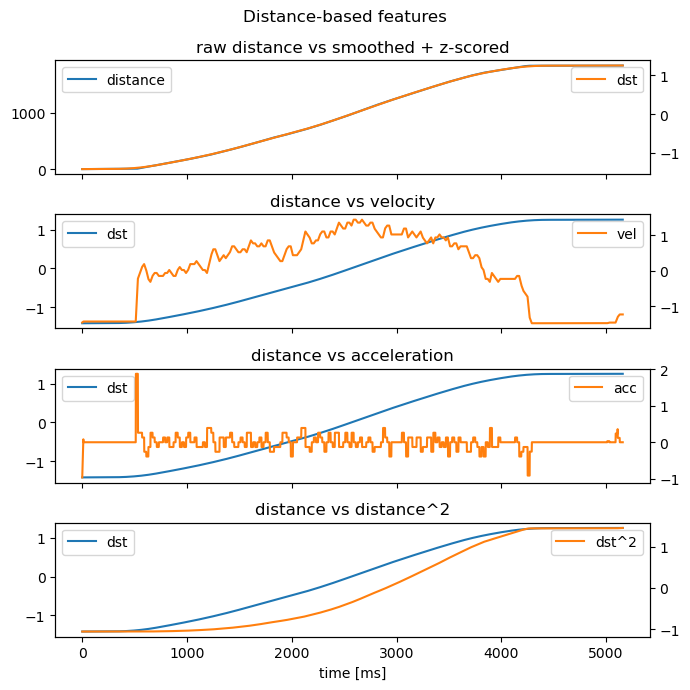

In [106]:
# plot distance and related features
n = 0 # select trial
df_r = dfs_raw[n]
df_p = dfs_proc[n] 

fig, axarr = plt.subplots(nrows=4, figsize=(7, 7))
fig.suptitle('Distance-based features')

def plot(df1, col1, df2, col2):
    'plot columns col1 from list1 of dataframes and col2 from list2 to secondary axis'
    y1 = df1.loc[:, col1]
    y2 = df2.loc[:, col2]
    x = steps2ms(np.arange(len(y1)))
    ax.plot(x, y1, color='C0', label=col1)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

    ax2 = ax.twinx()
    ax2.plot(x, y2, color='C1', label=col2)
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

ax = axarr[0]
plot(df_r, 'distance', df_p, 'dst')
ax.set_title('raw distance vs smoothed + z-scored')

ax = axarr[1]
plot(df_p, 'dst', df_p, 'vel')
ax.set_title('distance vs velocity')

ax = axarr[2]
plot(df_p, 'dst', df_p, 'acc')
ax.set_title('distance vs acceleration')

ax = axarr[3]
plot(df_p, 'dst', df_p, 'dst^2')
ax.set_title('distance vs distance^2')


for ax in axarr[:-1]:
    ax.set_xticklabels([])

ax = axarr[-1]
ax.set_xlabel('time [ms]')

fig.tight_layout()

In [94]:
dfs_p[0]

,dst,dst^2,dst^3,vel,acc,lck,rwd,unit_1,unit_2,unit_3,...,cue_2,cue_71,cue_141,cue_210,cue_280,cue_349,cue_419,cue_488,cue_558,cue_627
0,-1.415505,-1.056590,-0.913799,-1.461222,-0.964539,0.0,0.0,0.0,0.0,0.0,...,0.996917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.415498,-1.056590,-0.913799,-1.459163,-0.884261,0.0,0.0,0.0,0.0,0.0,...,0.998890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.415490,-1.056590,-0.913799,-1.457103,-0.803984,0.0,0.0,0.0,0.0,0.0,...,0.999877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.415483,-1.056590,-0.913799,-1.455043,-0.723706,0.0,0.0,0.0,0.0,0.0,...,0.999877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.415476,-1.056590,-0.913799,-1.452984,-0.643428,0.0,0.0,0.0,0.0,0.0,...,0.998890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6444,1.253531,1.452323,1.567497,-1.235024,-0.001205,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6445,1.253541,1.452407,1.567621,-1.235024,-0.001205,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6446,1.253552,1.452486,1.567738,-1.235024,-0.001205,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6447,1.253562,1.452559,1.567848,-1.235024,-0.001205,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


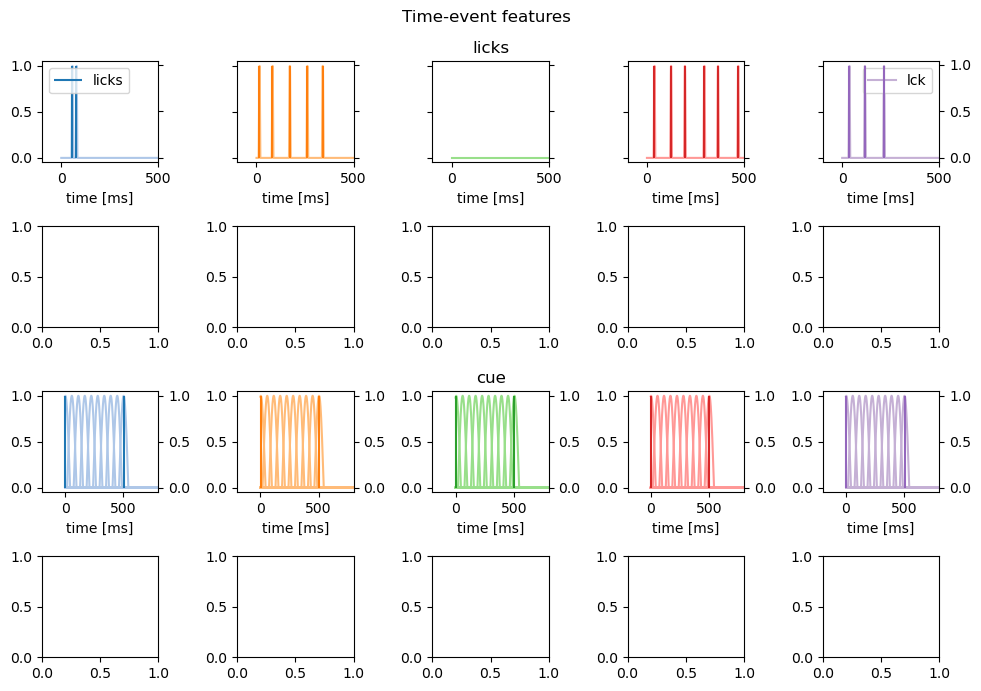

In [101]:
# plot time-event features and convolutions
dfs_r = [ dfs_raw[i] for i in range(5) ] # select first 20 trials
dfs_p = [ dfs_proc[i] for i in range(5) ] # select first 20 trials
n = len(dfs_r)

fig, axmat = plt.subplots(nrows=4, ncols=n, figsize=(10, 7))
fig.suptitle('Time-event features')
color1 = lambda x: plt.cm.tab20(x / 10)
color2 = lambda x: plt.cm.tab20((x + 0.5) / 10)

def plot_single(dfs1, col1, dfs2, col2):
    for i, (df1, df2, ax1) in enumerate(zip(dfs1, dfs2, axarr)):
        y1 = df1.loc[:, col1]
        y2 = df2.loc[:, col2]
        x = steps2ms(np.arange(len(y1)))
        ax1.vlines(x, 0, y1, color=color1(i), label=col1)
        ax1.set_zorder(1); ax1.set_frame_on(False)
        ax2 = ax1.twinx()
        ax2.plot(x, y2, color=color2(i), label=col2)
        if i != 0:
            ax1.set_yticklabels('')
        else:
            ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
        if i != len(axarr) - 1:
            ax2.set_yticklabels('')
        else:
            ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

def plot_block(dfs1, start, stop, dfs2, feat):
    for i, (df1, df2, ax1) in enumerate(zip(dfs1, dfs2, axarr)):
        y1  = df1.loc[:, start] + df1.loc[:, stop]
        x = steps2ms(np.arange(len(y1)))
        ax1.vlines(x, 0, y1, color=color1(i))
        ax1.set_zorder(1); ax1.set_frame_on(False)

        ax2 = ax1.twinx()
        for col in df2.columns:
            if col.startswith(feat):
                y2 = df2.loc[:, col]
                ax2.plot(x, y2, color=color2(i), label=col)
        #         y2 = df2.loc[:, col2]

        # ax2.plot(x, y2, color=color2(i), label=col2)
        # if i != 0:
        #     ax1.set_yticklabels('')
        # else:
        #     ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
        # if i != len(axarr) - 1:
        #     ax2.set_yticklabels('')
        # else:
        #     ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

axarr = axmat[0]
plot_single(dfs_r, 'licks', dfs_p, 'lck')
ax = axarr[2]
ax.set_title('licks')
for ax in axarr:
    ax.set_xlim(-100, 500)
    ax.set_xlabel('time [ms]')

axarr = axmat[2]
plot_block(dfs_r, 'cue_on', 'cue_off', dfs_p, 'cue_')
ax = axarr[2]
ax.set_title('cue')
for ax in axarr:
    ax.set_xlim(-200, 800)
    ax.set_xlabel('time [ms]')


# for axarr in axmat[:-1]:
#     for ax in axarr[:-1]:
#         ax.set_xticklabels([])
# axarr = axmat[-1]
# for i, ax in enumerate(axarr):
#     ax.set_xlabel('time [ms]\n trial {}'.format(str(i)))

fig.tight_layout()

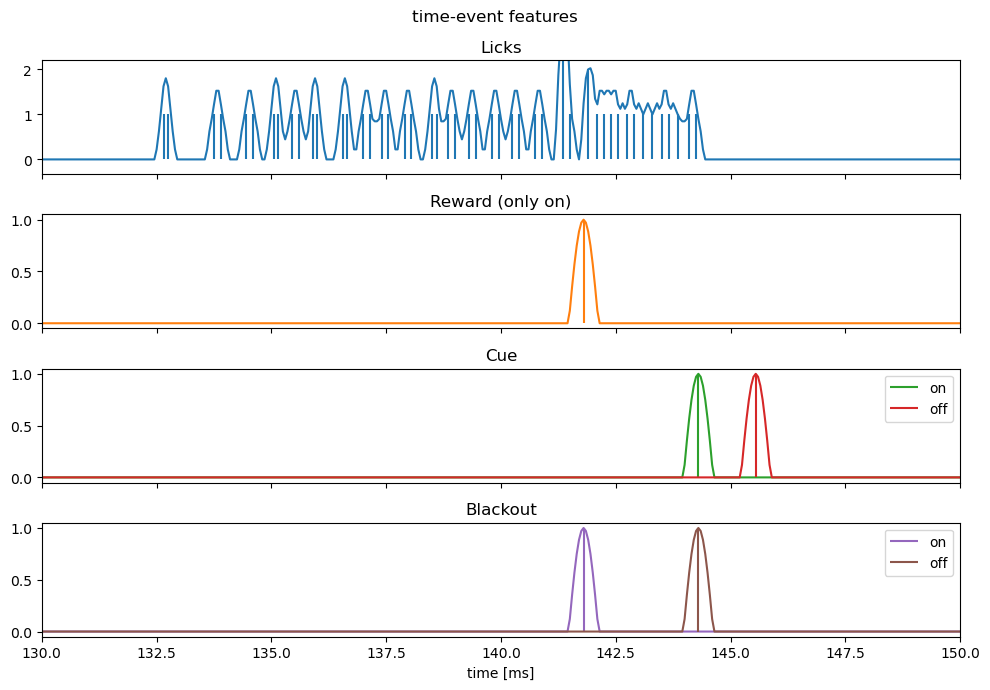

In [17]:
# plot time-event features and convolutions
fig, axarr = plt.subplots(nrows=4, figsize=(10, 7))
fig.suptitle('time-event features')
xi, xf = 130, 150

line = lambda x, l, c: ax.plot(np.arange(len(x)) / 20, x, label=l, color=c, zorder=-99)
vlines = lambda x, l, c: ax.vlines(np.arange(len(x)) / 20, 0, x, label=l, color=c, zorder=-99)
lo = 1.4

ax = axarr[0]
ax.set_title('Licks')
vlines(lck_train, 'licks', 'C0')
line(lck_conv, 'raised cosines', 'C0')
ax.set_ylim(top=2.2)

ax = axarr[1]
ax.set_title('Reward (only on)')
vlines(rwd_train, 'reward', 'C1')
line(rwd_conv, 'raised cosines', 'C1')

ax = axarr[2]
ax.set_title('Cue')
vlines(cue_on_train, 'on', 'C2')
line(cue_on_conv, '', 'C2')
vlines(cue_off_train, 'off', 'C3')
line(cue_off_conv, '', 'C3')
ax.legend()

ax = axarr[3]
ax.set_title('Blackout')
vlines(blk_on_train, 'on', 'C4')
line(blk_on_conv, '', 'C4')
vlines(blk_off_train, 'off', 'C5')
line(blk_off_conv, '', 'C5')
ax.legend()

for ax in axarr:
    ax.set_xlim(xi, xf)
for ax in axarr[:-1]:
    ax.set_xticklabels([])
ax = axarr[-1]
ax.set_xlabel('time [ms]')

fig.tight_layout()